In [1]:
 !unzip /content/drive/MyDrive/leaf_disease_data.zip> /dev/null


**DATA PREPROCESSING
**

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator  ,image_utils 
from keras.applications.vgg19 import VGG19 , preprocess_input, decode_predictions

In [3]:
#number of classes
len(os.listdir("/content/Plant_leaf_diseases_dataset_with_augmentation"))

39

In [4]:
train_datagen=ImageDataGenerator(zoom_range=0.5,shear_range=0.3,horizontal_flip=True,preprocessing_function=preprocess_input)


val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train=train_datagen.flow_from_directory(directory="/content/Plant_leaf_diseases_dataset_with_augmentation",target_size=(256,256),batch_size=32)

val=val_datagen.flow_from_directory(directory="/content/Plant_leaf_diseases_dataset_with_augmentation",target_size=(256,256),batch_size=32)

Found 61486 images belonging to 39 classes.
Found 61486 images belonging to 39 classes.


In [6]:
t_img,label=train.next()

In [7]:
t_img.shape

(32, 256, 256, 3)

In [8]:
def plotImage(img_arr,label):
 
  for im , l in zip(img_arr,label):
    plt.figure(figsize=(5,5))
    plt.imshow(im)
    plt.show()


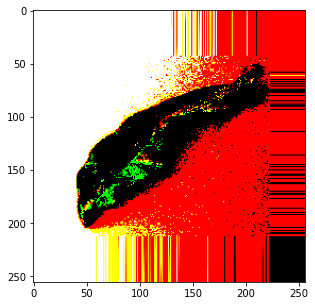

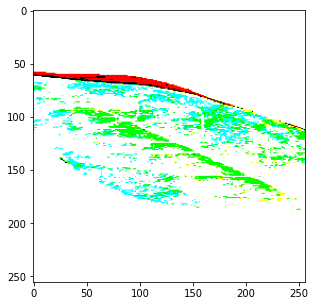

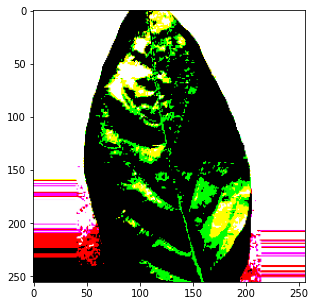

In [9]:
plotImage(t_img[:3],label[:3])

**MODEL BUILDING**

In [10]:
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [11]:
base_model=VGG19(input_shape=(256,256,3),include_top=False)

80134624/80134624 [==============================] - 6s 0us/step


In [12]:
for layer in base_model.layers:
  layer.trainable=False

In [13]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
X=Flatten()(base_model.output)
X=Dense(units=39,activation='softmax')(X)

# creating a model
model=Model(base_model.input,X)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [16]:
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

**EARLY STOPPING AND MODEL CHECK POINT**

In [17]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [18]:
#early stopping
es=EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)

#model check point
mc=ModelCheckpoint(filepath="best_model.h5",monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1,save_best_only=True)


cb=[es,mc]

In [19]:
his=model.fit_generator(train, 
                        steps_per_epoch=16,
                        epochs=50,
                        verbose=1,
                        callbacks=cb,
                        validation_data=val,
                        validation_steps=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 23.8470 - accuracy: 0.2520
Epoch 1: val_accuracy improved from -inf to 0.39648, saving model to best_model.h5
16/16 [==============================] - 23s 780ms/step - loss: 23.8470 - accuracy: 0.2520 - val_loss: 16.4564 - val_accuracy: 0.3965
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 13.5981 - accuracy: 0.5020
Epoch 2: val_accuracy improved from 0.39648 to 0.64258, saving model to best_model.h5
16/16 [==============================] - 14s 878ms/step - loss: 13.5981 - accuracy: 0.5020 - val_loss: 10.0890 - val_accuracy: 0.6426
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 11.8401 - accuracy: 0.5645
Epoch 3: val_accuracy improved from 0.64258 to 0.69727, saving model to best_model.h5
16/16 [==============================] - 13s 791ms/step - loss: 11.8401 - accuracy: 0.5645 - val_loss: 8.8742 - val_accuracy: 0.6973
Epoch 4/50
16/16 [==============================] - ETA: 0s

In [20]:
h=his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

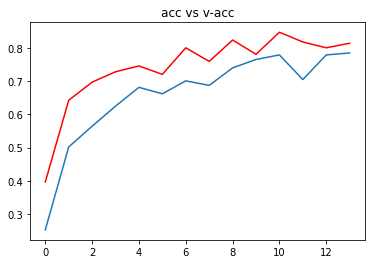

In [21]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c="red")
plt.title("acc vs v-acc")
plt.show()

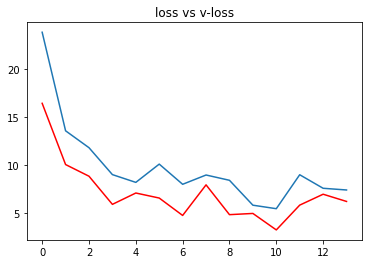

In [22]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c="red")
plt.title("loss vs v-loss")
plt.show()

In [25]:
#load best model
from keras.models import load_model
model=load_model("/content/best_model.h5")

In [27]:
acc=model.evaluate_generator(val)[1]
print(f"The accuracy of your model is={acc*100}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


The accuracy of your model is=83.68409276008606%


In [31]:
ref=dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))

In [52]:

def prediction(path): 
  img=tf.keras.utils.load_img(path,target_size=(256,256)) 
  i=tf.keras.utils.img_to_array(img) 
  im=preprocess_input(i) 
  img=np.expand_dims(im,axis=0) 
  pred=np.argmax(model.predict(img)) 
  print(f"The image belongs to {ref[pred]}")

In [56]:
path="/content/Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1004).JPG"
prediction(path)

1/1 [==============================] - 0s 18ms/step
The image belongs to Tomato___Tomato_Yellow_Leaf_Curl_Virus
